In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from functools import reduce

sys.path.append('../functions/')
from functions import load_lat_lon_area, display_map, reverse_mask, nanaverage, nanstd, display_number_of_runs



# Choices of X and Y 

In [3]:
scenario   = "ssp245" # ssp126, ssp245 ou ssp585

#------- Y
anomalie_Y = False
min_Y      = 2091
max_Y      = 2100
min_Y_ref  = 1850
max_Y_ref  = 1900

#------- X
X_choice = "mean" # mean, trend
min_X    = 1900 # 1900 or 1975
max_X    = 2020

#------- X en multivarié : est ce qu'on inclue l'AMOC passé en plus des 18 features ?
include_AMOC_in_predictors=True

# Import data

C:\Users\vportmann\.conda\envs\article3_6\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\article3_6\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


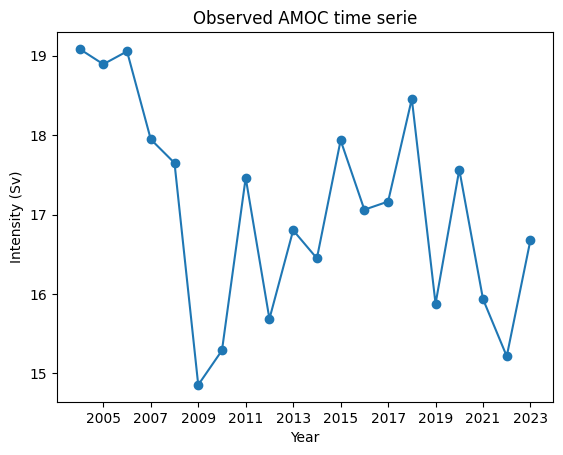

,name model,number of runs
1,ACCESS-CM2,3
2,ACCESS-ESM1-5,30
3,CAS-ESM2-0,2
4,CESM2,3
5,CESM2-WACCM,3
6,CIESM,1
7,CMCC-CM2-SR5,1
8,CMCC-ESM2,1
9,CNRM-CM6-1,6
10,CNRM-CM6-1-HR,1


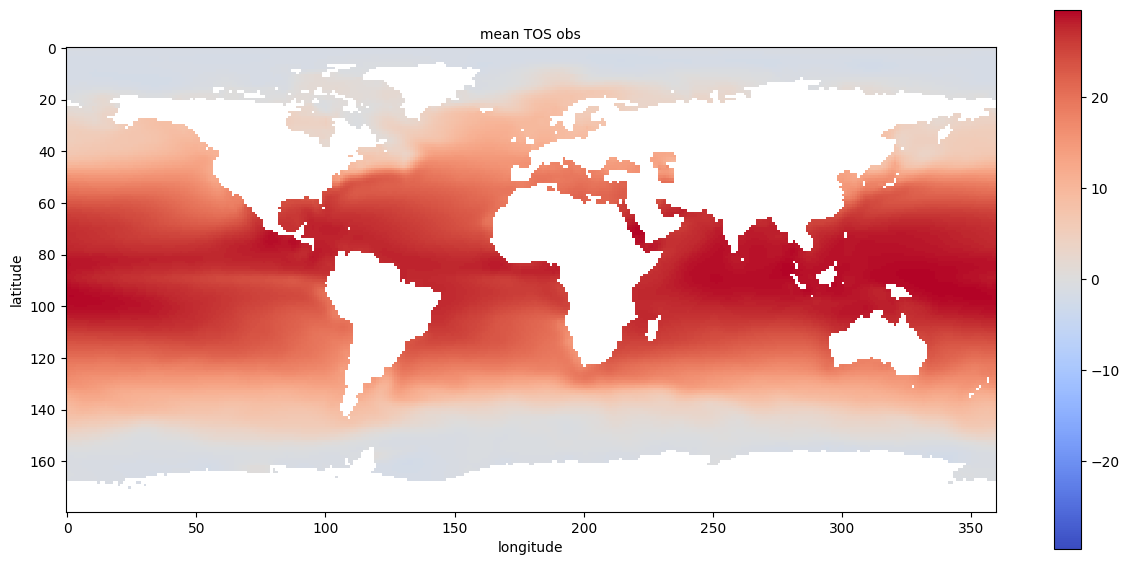

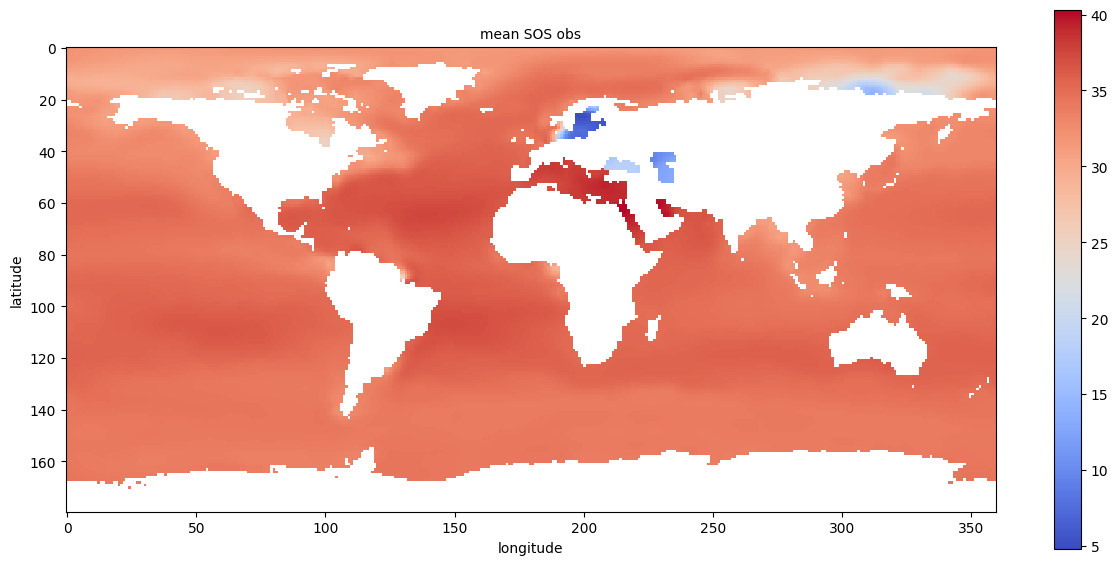

792 cells
792 cells
601 cells
601 cells
801 cells
801 cells
2207 cells
2207 cells
850 cells
850 cells
788 cells
788 cells
1663 cells
1663 cells
3332 cells
3332 cells
820 cells
820 cells


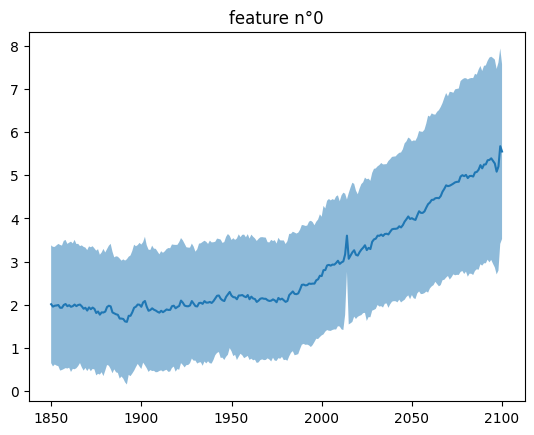

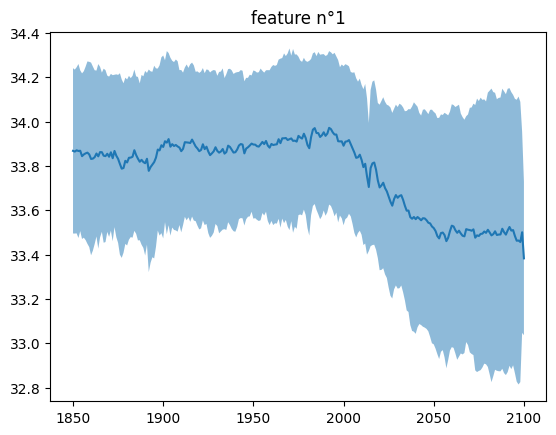

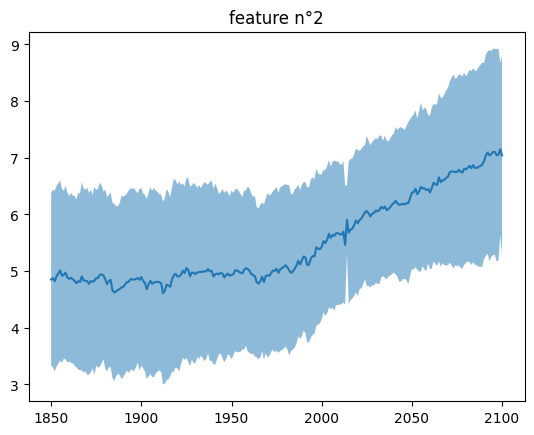

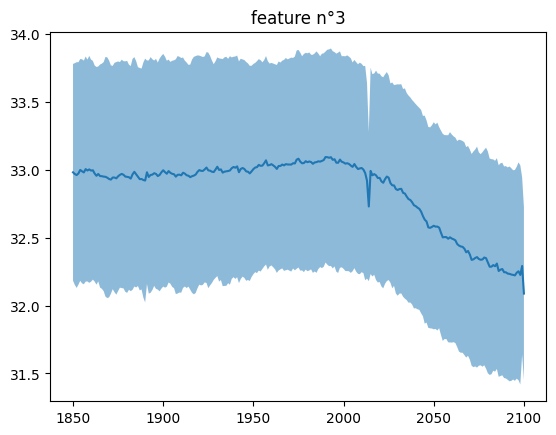

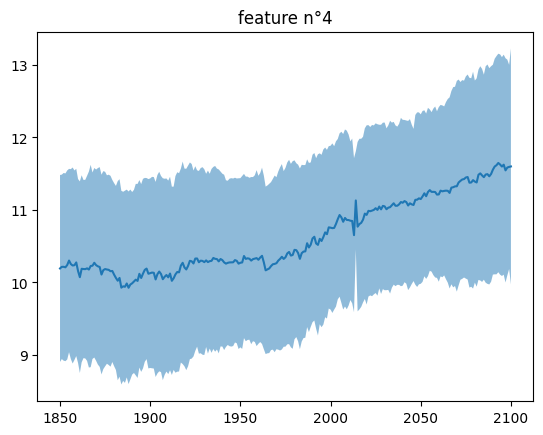

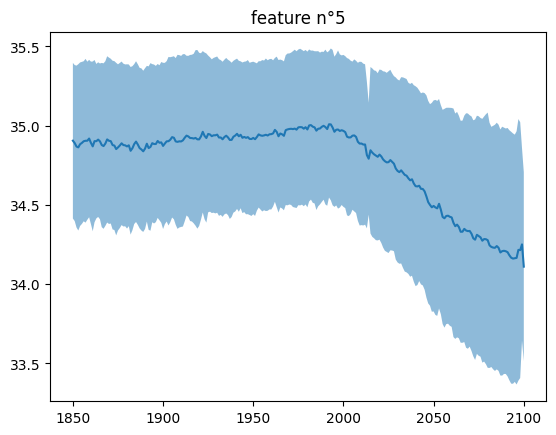

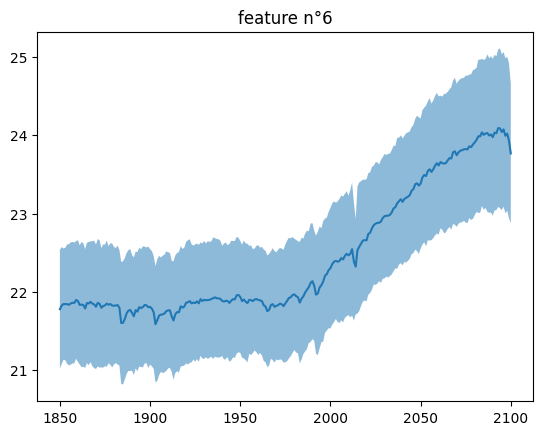

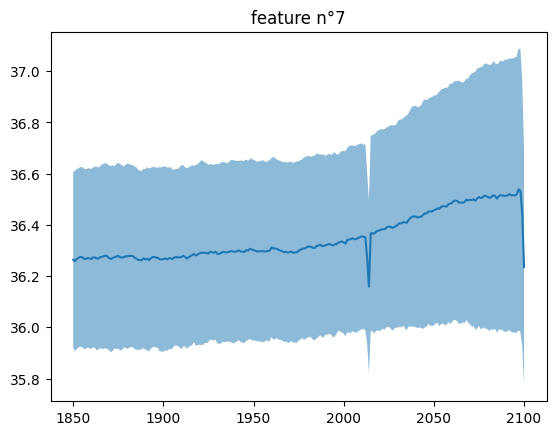

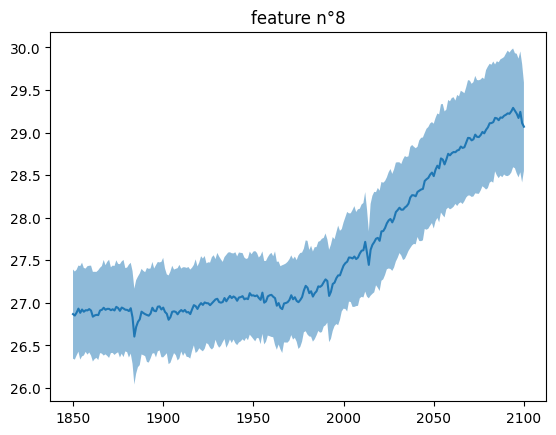

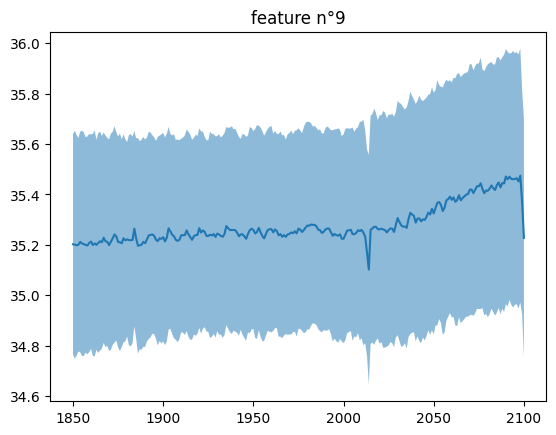

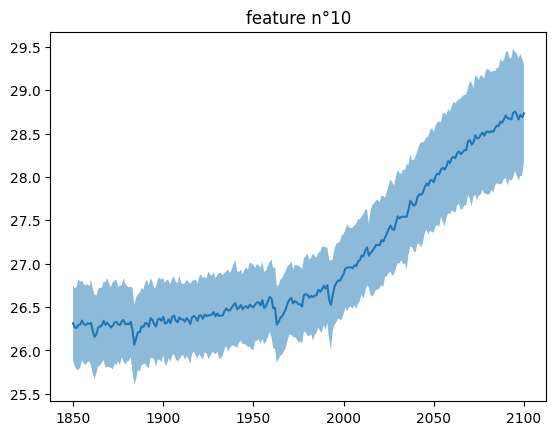

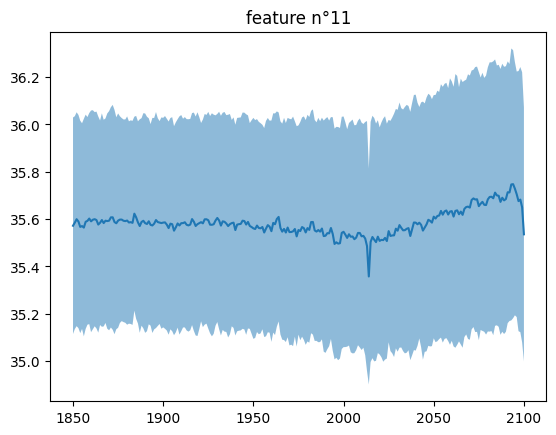

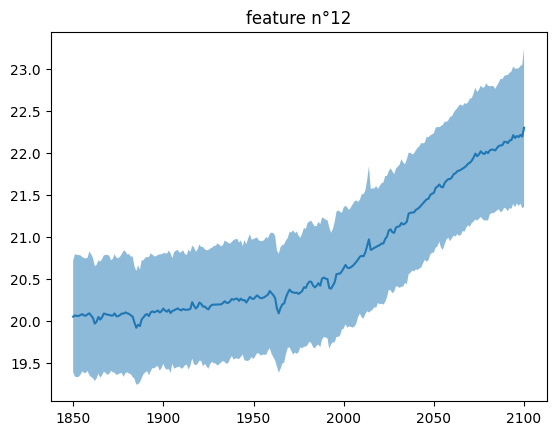

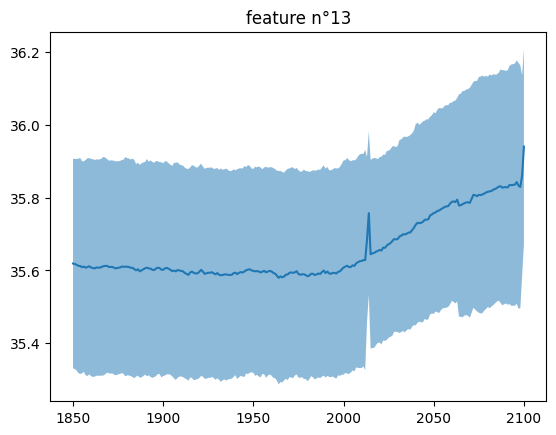

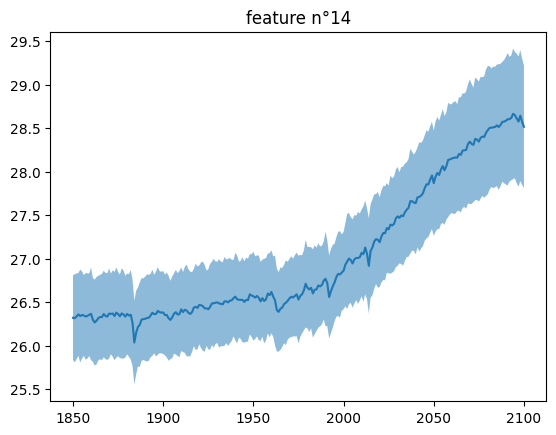

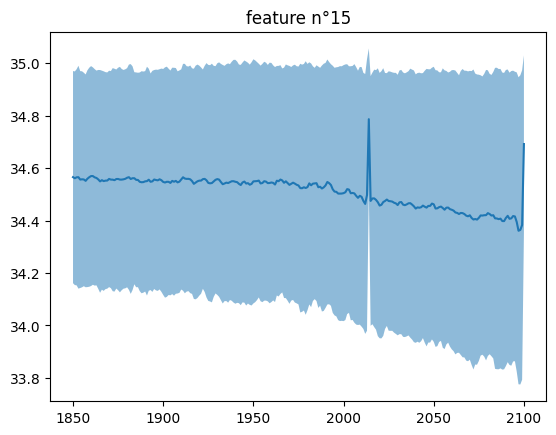

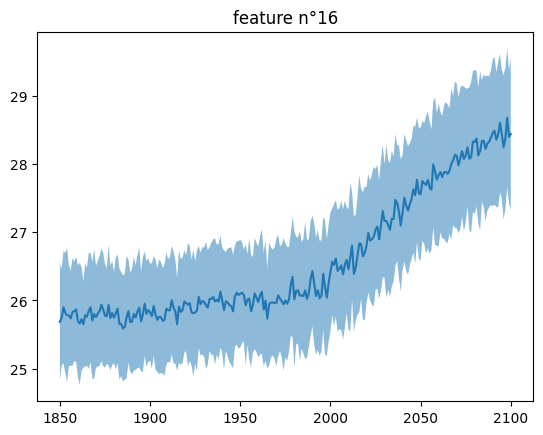

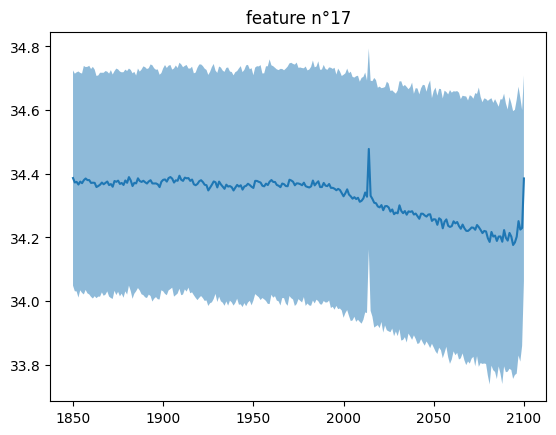

In [4]:
from import_data import import_CMIP6_TOS_SOS, import_CMIP6_AMOC, select_common_members, import_AMOC_obs, import_TOS_SOS_obs, region_average_TOS_SOS_obs, display_regions

#---- Import labels longitudes and latitudes
latitudes, longitudes, area_perLat_per_Lon = load_lat_lon_area("../data/area_r360x180.nc")
longitudes[longitudes>180] -= 360

#---- Import CMIP6 TOS and SOS
years_to_select = np.arange(1850, 2100+1)
[X_simu_perSample_perYear_perFeature_bis, name_samples_X, nb_var, list_name_per_var
            ] = import_CMIP6_TOS_SOS(scenario, years_to_select)

#---- Import CMIP6 AMOC
[hist_times, hist_name_samples, hist_AMOC, ssp_times, ssp245_name_samples, ssp245_AMOC
        ] = import_CMIP6_AMOC(scenario)

#---- Select only the members that are available for both TOS, SOS and AMOC
[X_simu_perSample_perYear_perFeature, Y, times_Y, final_name_samples
        ] = select_common_members(name_samples_X, hist_name_samples, ssp245_name_samples,
                         X_simu_perSample_perYear_perFeature_bis,
                         years_to_select, hist_times, ssp_times,
                         hist_AMOC, ssp245_AMOC)

#---- Import AMOC observations (RAPID)
obs_AMOC_times, obs_AMOC_values = import_AMOC_obs(display=True)

#---- Display the number of members given by each climate model
final_name_models, final_weight_per_sample = display_number_of_runs(final_name_samples, display=True)

#---- Import TOS and SOS observations
[ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
 obs_times, mask_perVar
        ] = import_TOS_SOS_obs(years_to_select, display=True)

[X_obs_perYear_perFeature, X_obsVar_perYear_perFeature,
 name_perBox, list_idCell_perFeature, list_id_box_perFeature,
 list_id_var_perFeature, colors_perBox,
 middle_cell_perBox, list_name_perFeature, nb_box
        ] = region_average_TOS_SOS_obs(longitudes, latitudes, X_simu_perSample_perYear_perFeature,
                               ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
                               area_perLat_per_Lon, list_name_per_var, obs_times, mask_perVar,
                               final_weight_per_sample, years_to_select, display=True)





# Figure S1: Display the regions

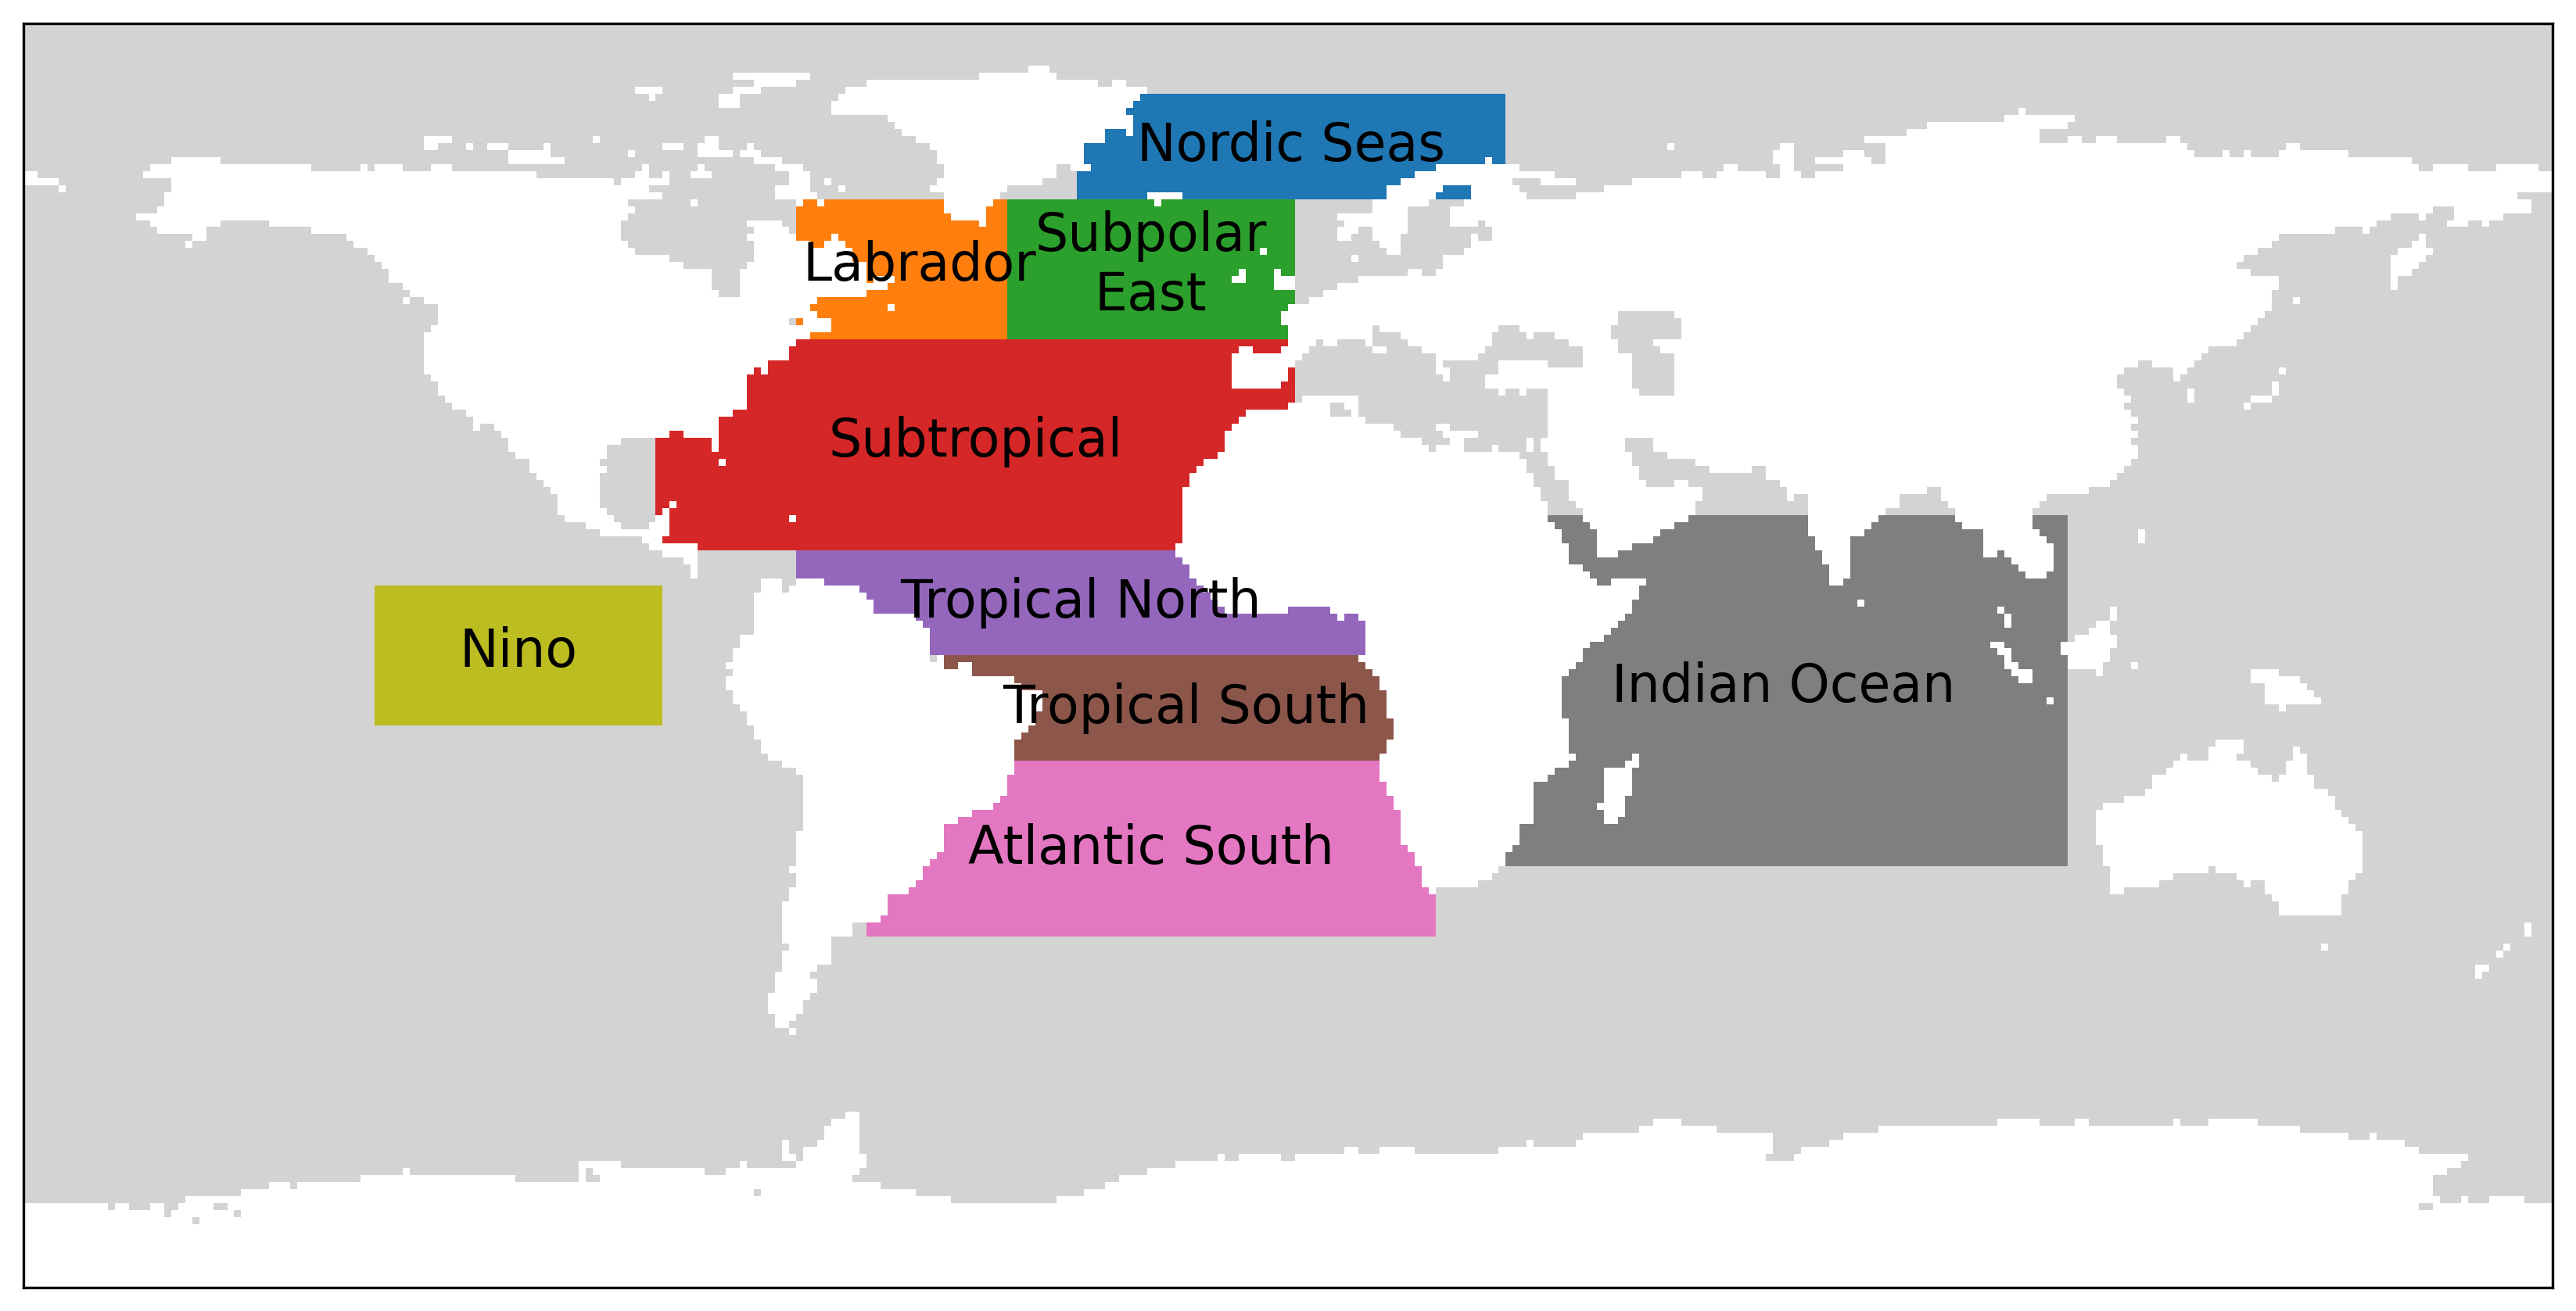

In [5]:
display_regions(
    mask_perVar, name_perBox, list_idCell_perFeature,
    list_id_box_perFeature, list_id_var_perFeature, colors_perBox,
    latitudes, longitudes, middle_cell_perBox)

# Format data into X and Y

In [6]:
from format_data import create_X_AMOC_feature, create_X_TOS_SOS_features, create_Y_AMOC_feature, average_member_perModel

#------- X definition for the AMOC
[name_X_AMOC, X_simu_AMOC, X_obs_AMOC, X_AMOC_mean_1850_1900
        ] = create_X_AMOC_feature(X_choice, Y, times_Y, obs_AMOC_values, obs_AMOC_times)
print("{} (RAPID) is {:.2f} Sv.".format(name_X_AMOC, X_obs_AMOC))

#------- X definition for the TOS and SOS
X_obs, X_simu = create_X_TOS_SOS_features(X_choice, min_X, max_X, 
                                          X_obs_perYear_perFeature, obs_times,
                                          X_simu_perSample_perYear_perFeature, years_to_select)

#------- Y definition for the AMOC
Y_simu, name_Y, Y_ref = create_Y_AMOC_feature(anomalie_Y, min_Y, max_Y,
                          min_Y_ref, max_Y_ref,
                          Y, years_to_select)

#------- Select only the run without nan values
model_to_keep     = np.logical_not(np.isnan(Y_simu))
Y_ref             = Y_ref[model_to_keep]
Y_simu            = Y_simu[model_to_keep]
X_simu            = X_simu[model_to_keep]
X_simu_AMOC       = X_simu_AMOC[model_to_keep]
final_name_samples = final_name_samples[model_to_keep]
final_name_models  = np.array(final_name_models)[model_to_keep]
X_AMOC_mean_1850_1900   = X_AMOC_mean_1850_1900[model_to_keep]

#------- Combine (or not) the X SST and SSS features with the X AMOC feature
if include_AMOC_in_predictors:
    X_simu = np.concatenate((X_simu, X_simu_AMOC.reshape(-1,1)), axis=1)
    X_obs  = np.concatenate((X_obs, X_obs_AMOC.reshape(-1)))
    list_name_perFeature.append(name_X_AMOC)
    list_id_var_perFeature.append(2)
    
#------- Average each model on its available members
[uniques_models, Y_simu_resampled, Y_ref_resampled, X_simu_resampled, X_simu_AMOC_resampled, X_AMOC_mean_1850_1900_resampled
        ] = average_member_perModel(final_name_models, X_simu, Y_simu,
                            Y_ref, X_simu_AMOC, X_AMOC_mean_1850_1900)
nb_models = len(uniques_models)

#------- Replacement
X_simu                = X_simu_resampled
Y_simu                = Y_simu_resampled
Y_ref                 = Y_ref_resampled
X_simu_AMOC           = X_simu_AMOC_resampled
X_AMOC_mean_1850_1900 = X_AMOC_mean_1850_1900_resampled
final_name_models     = np.copy(uniques_models)


mean AMOC 2005-2023 (RAPID) is 16.95 Sv.


C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:99: RuntimeWarning: Mean of empty slice
  Y_simu_anom = np.nanmean(Y_anom[:, times_to_mean], axis=1)
C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:106: RuntimeWarning: Mean of empty slice
  Y_simu = np.nanmean(Y[:, times_to_mean], axis=1)


# Comparison of the performances of different observational constraint methods (this step takes a lot of time)

In [7]:
from OC_methods import performances_methods
return_LOOperFold = True
[name_methods, list_list_predictions, list_list_std_without, list_list_LOO, poids_wA
        ] = performances_methods(X_simu_AMOC, X_obs_AMOC, X_simu, X_obs, Y_simu, return_LOOperFold=return_LOOperFold)

MMM

wAverage

LR

Ridge

RF

MMM

wAverage

LR

Ridge

RF



In [8]:
id_ridge  = 3

print("How many percent ridge regression makes a better cross-validation error than other methods:")
for id_method in range(len(name_methods)):
    if return_LOOperFold:
        LOO = np.mean(list_list_LOO[1][id_method])
        LOO_ridge = np.mean(list_list_LOO[1][id_ridge])
    else:
        LOO = list_list_LOO[1][id_method]
        LOO_ridge = list_list_LOO[1][id_ridge]
    print("\t{}: {:.0f}%".format(name_methods[id_method], 100*(LOO-LOO_ridge)/LOO))
    

How many percent ridge regression makes a better cross-validation error than other methods:
	Multi-Model
Mean: 60%
	Weighted
Average: 58%
	Linear
Regression: 29%
	Ridge
Regression: 0%
	Random
Forest: 38%


# Results: Figure 3

In [34]:
from display_results import plot_performances, display_univariate_WeightedAverage_LinearRegression

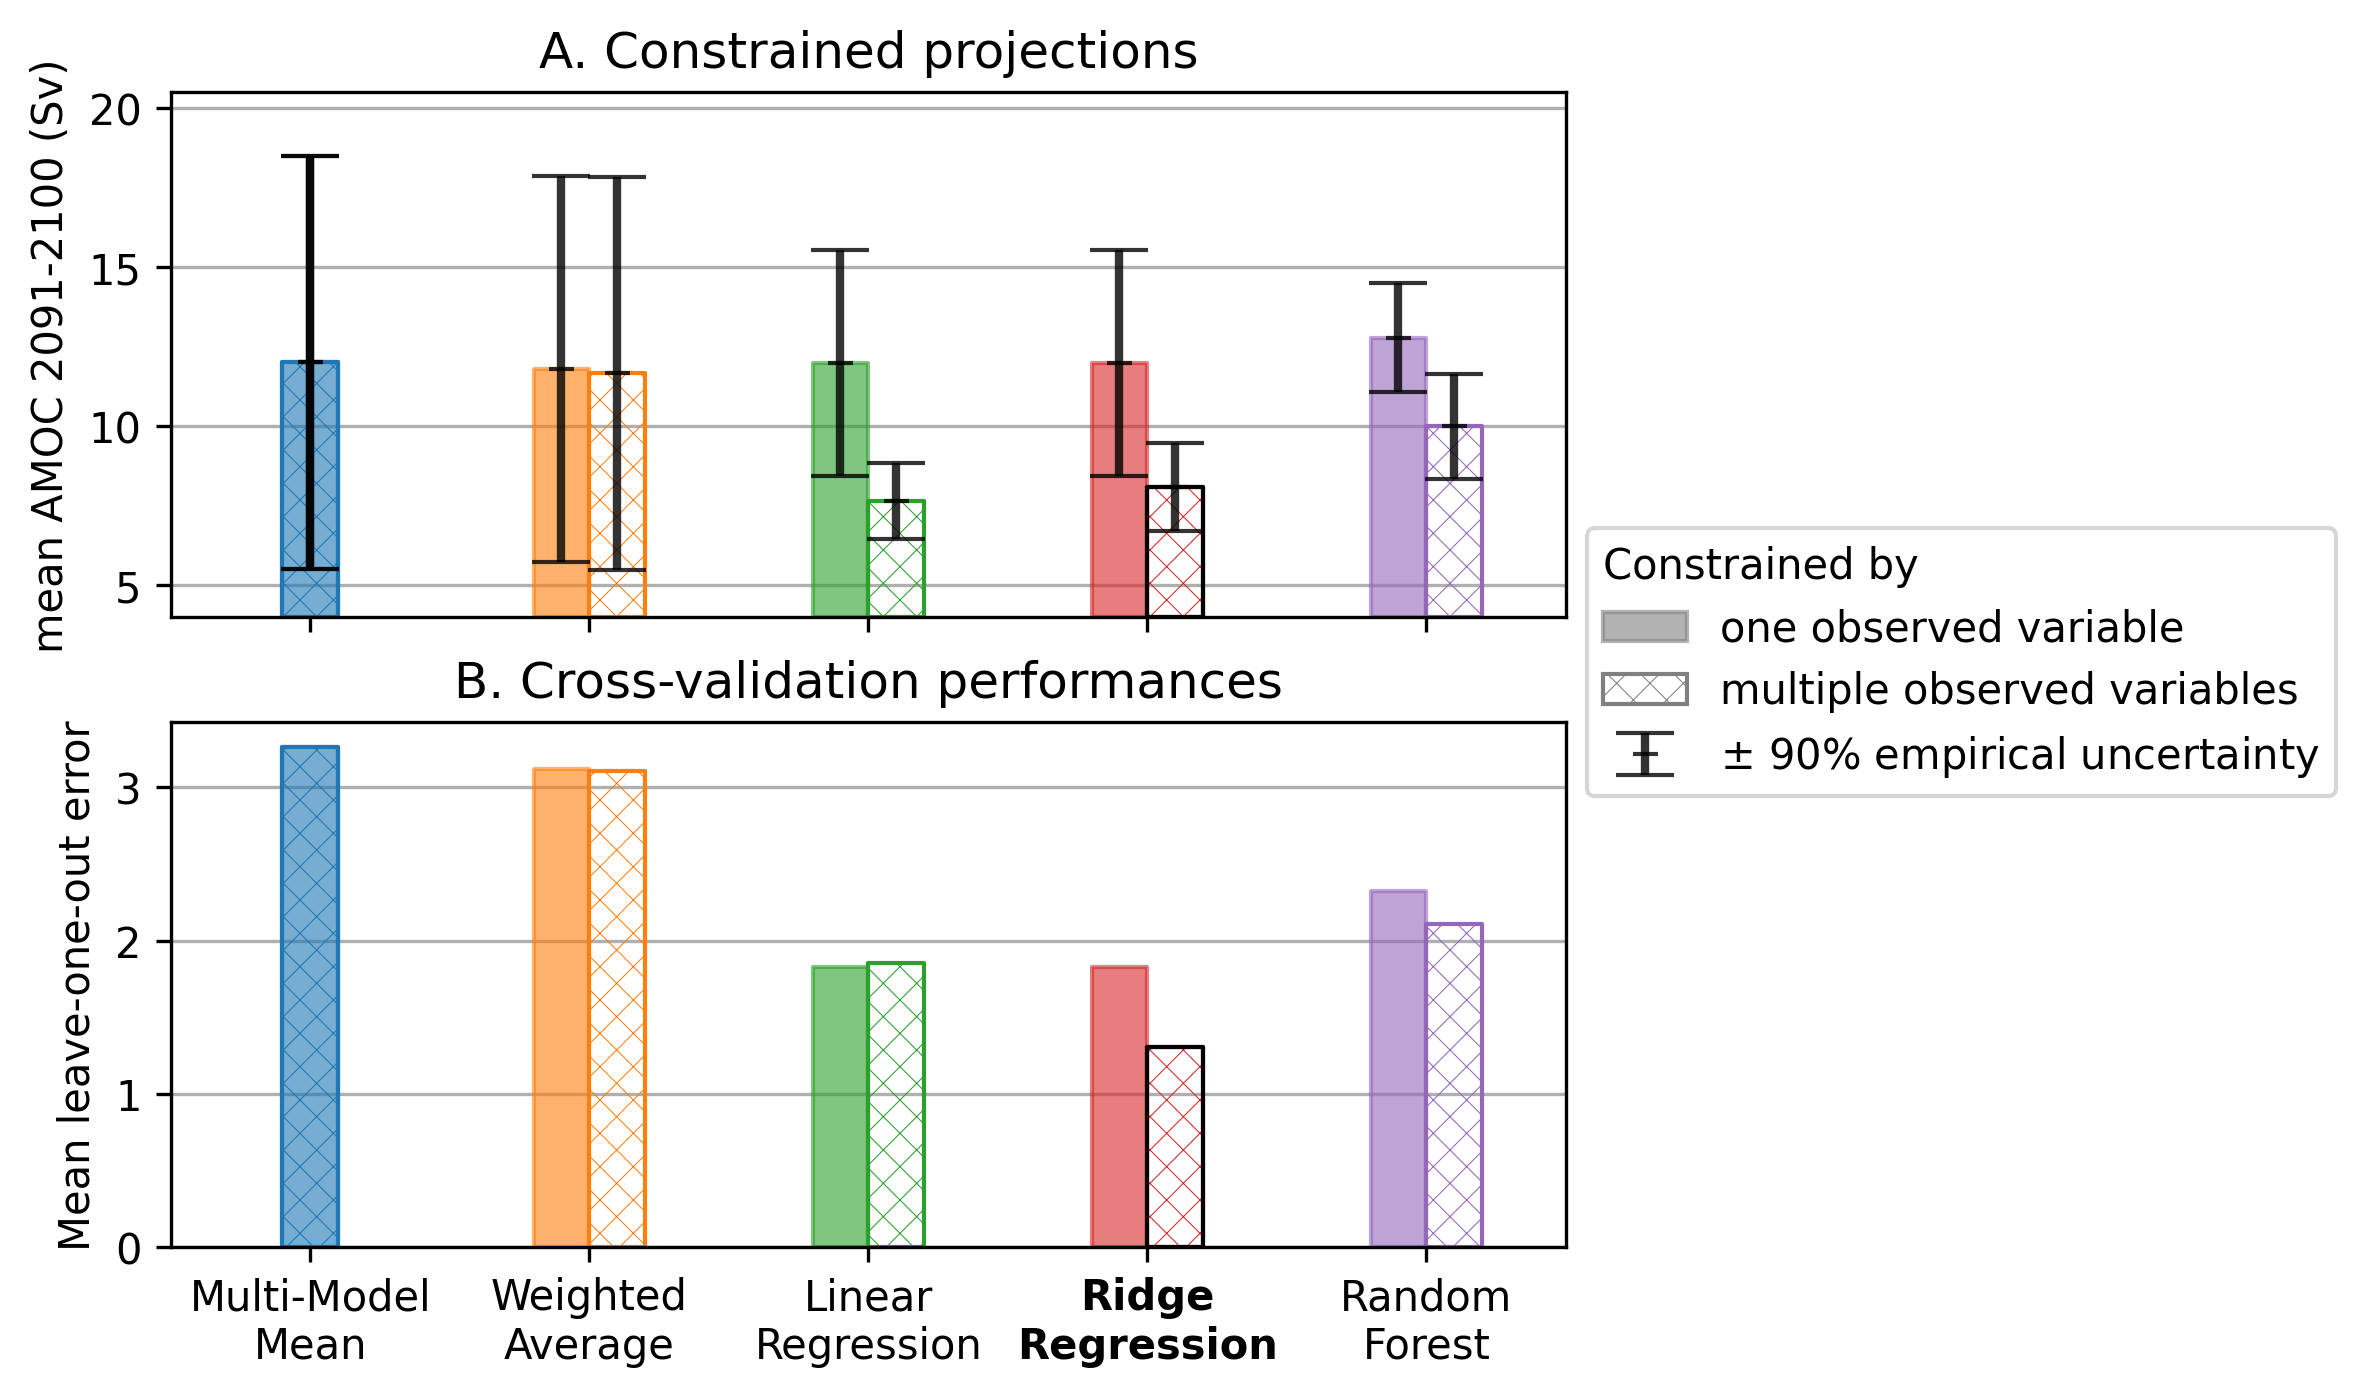

In [43]:
name_methods = ["Multi-Model\nMean", "Weighted\nAverage", "Linear\nRegression", "Ridge\nRegression", "Random\nForest"]
plot_performances(name_methods, scenario, X_choice, anomalie_Y, name_Y,
                      list_list_predictions, list_list_std_without, list_list_LOO, return_LOOperFold=return_LOOperFold)  
    

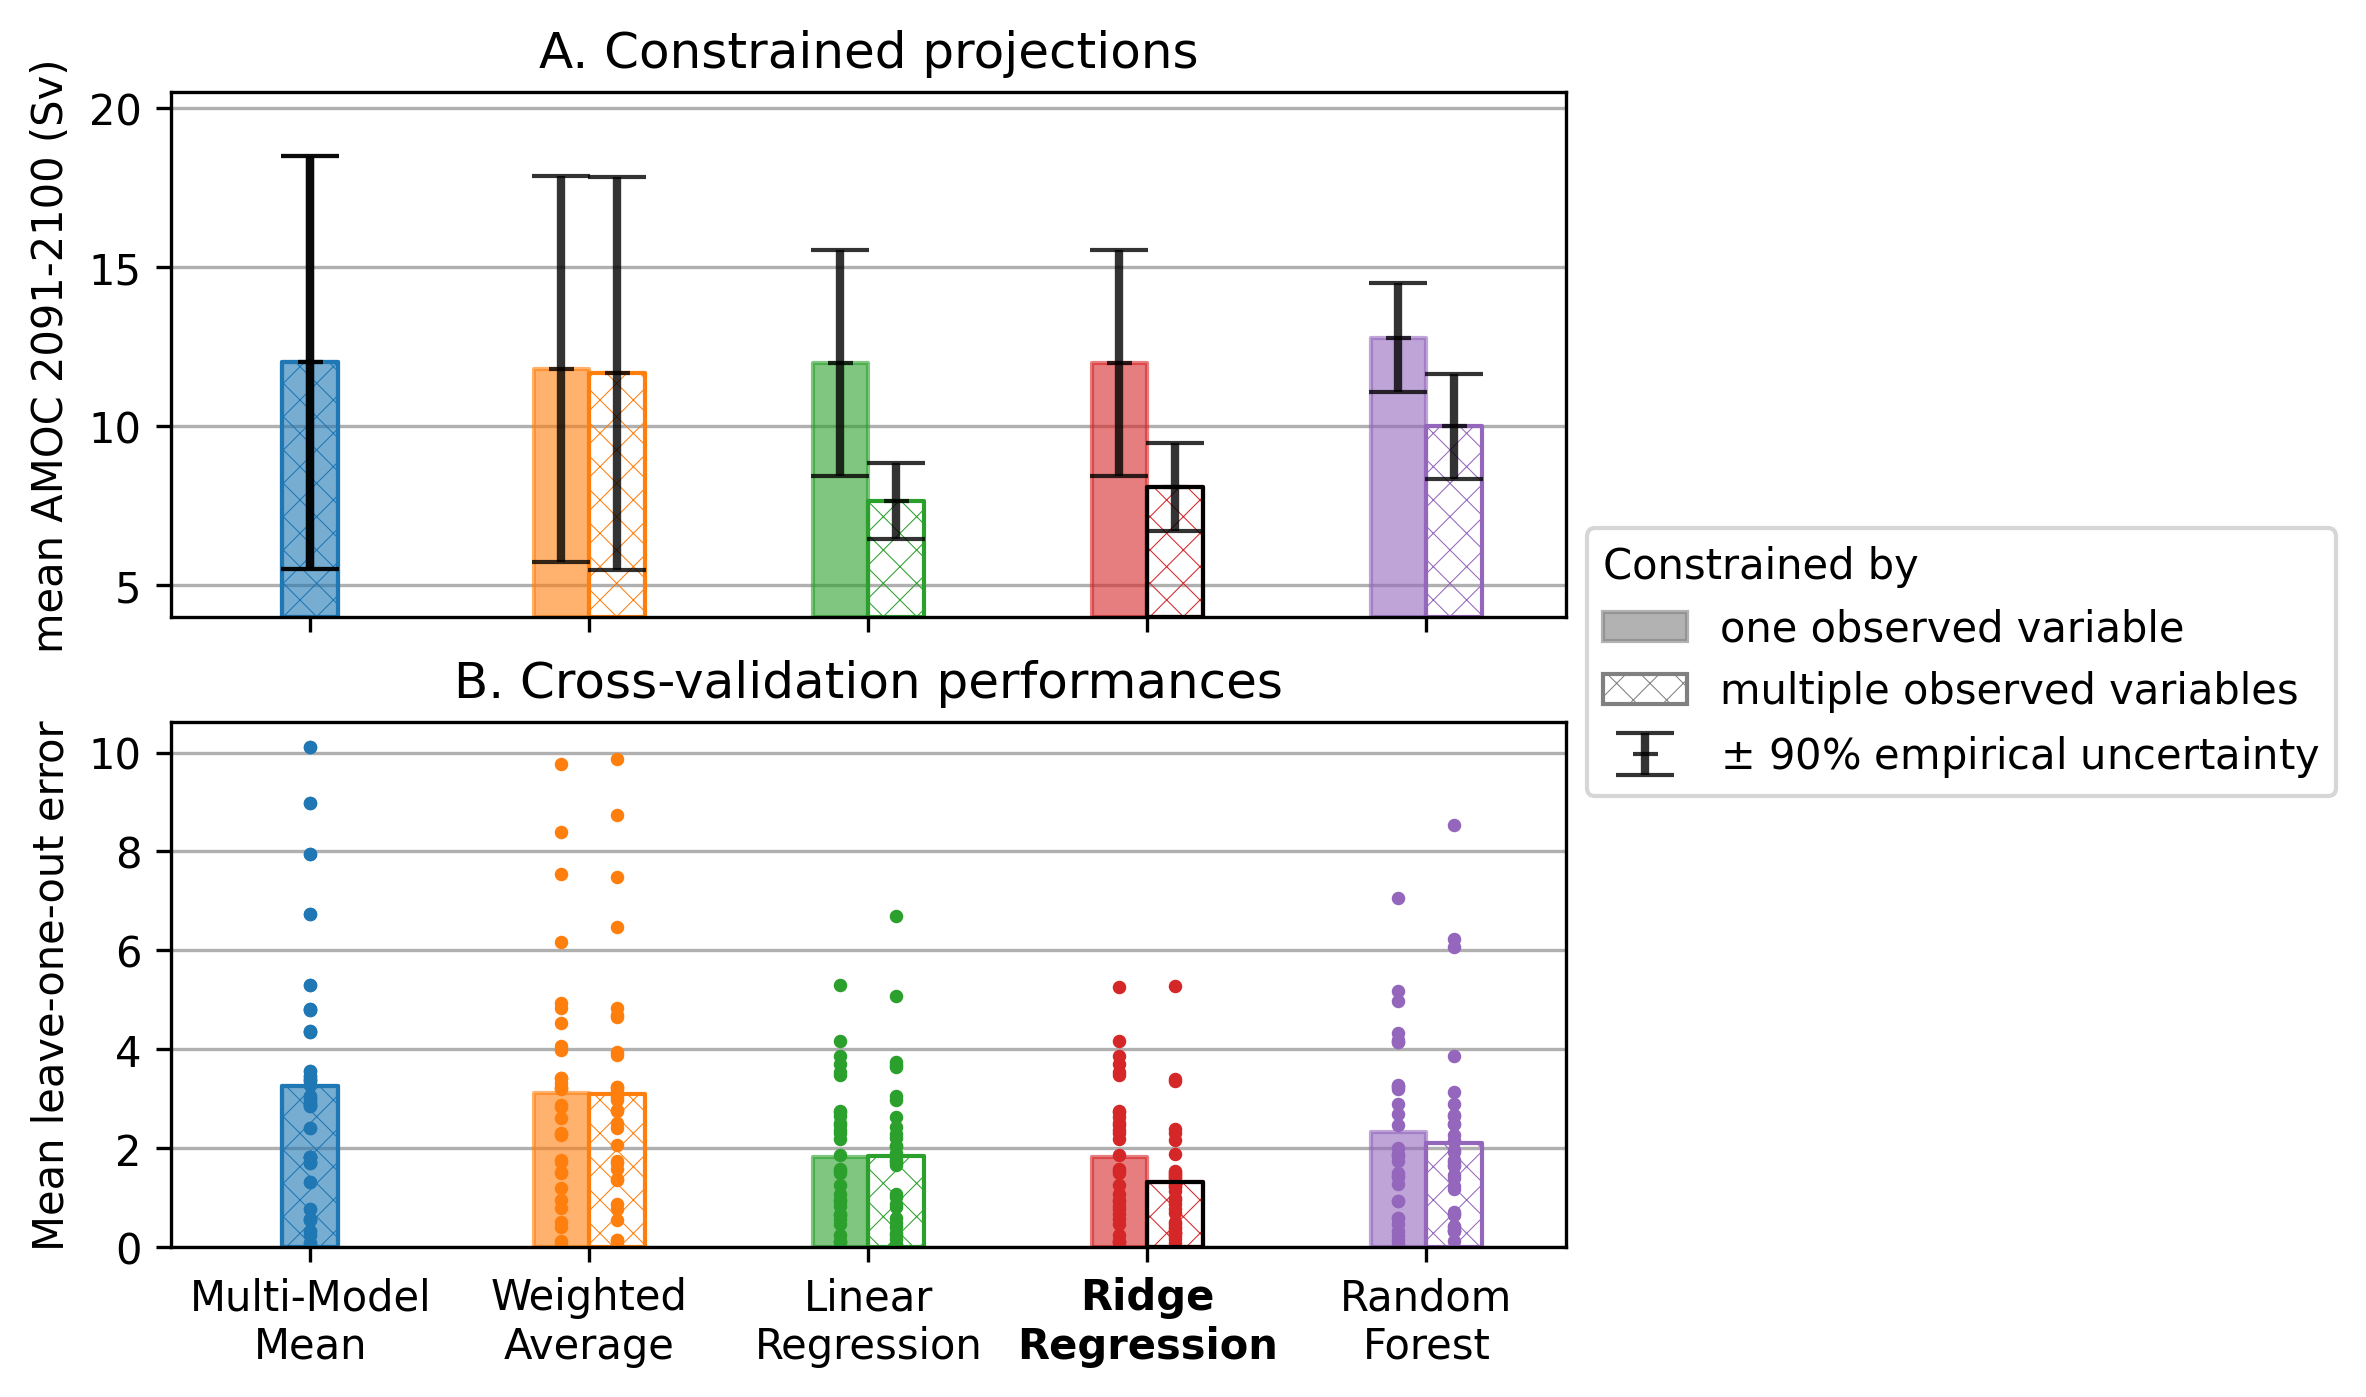

In [52]:
name_methods = ["Multi-Model\nMean", "Weighted\nAverage", "Linear\nRegression", "Ridge\nRegression", "Random\nForest"]
plot_performances(name_methods, scenario, X_choice, anomalie_Y, name_Y,
                      list_list_predictions, list_list_std_without, list_list_LOO, return_LOOperFold=return_LOOperFold, display_LOOperFold=True)  
    

# Values in the article

In [13]:
name_methods = ["Multi-Model Mean", "Weighted Average", "Linear Regression", "Ridge Regression", "Random Forest"]

id_X_choice, id_method = np.where(list_list_std_without==np.min(list_list_std_without))
id_X_choice, id_method = id_X_choice[0], id_method[0]
std = list_list_std_without[id_X_choice][id_method]


std_MMM = list_list_std_without[0][0]
if return_LOOperFold:
    LOO_MMM = np.mean(list_list_LOO[0][0])
    LOO = np.mean(list_list_LOO[id_X_choice][id_method])
else:
    LOO_MMM = list_list_LOO[0][0]
    LOO = list_list_LOO[id_X_choice][id_method]
    
print("{} reduction of uncertainty: {:.1f} %".format(name_methods[id_method], int(100*(std_MMM-std)/std_MMM)))
print("{} reduction of cross-validation error: {:.1f} %".format(name_methods[id_method], int(100*(LOO_MMM-LOO)/LOO_MMM)))




Linear Regression reduction of uncertainty: 81.0 %
Linear Regression reduction of cross-validation error: 43.0 %


# Illustration of weighted average and linear regression in univariate: Figure S2

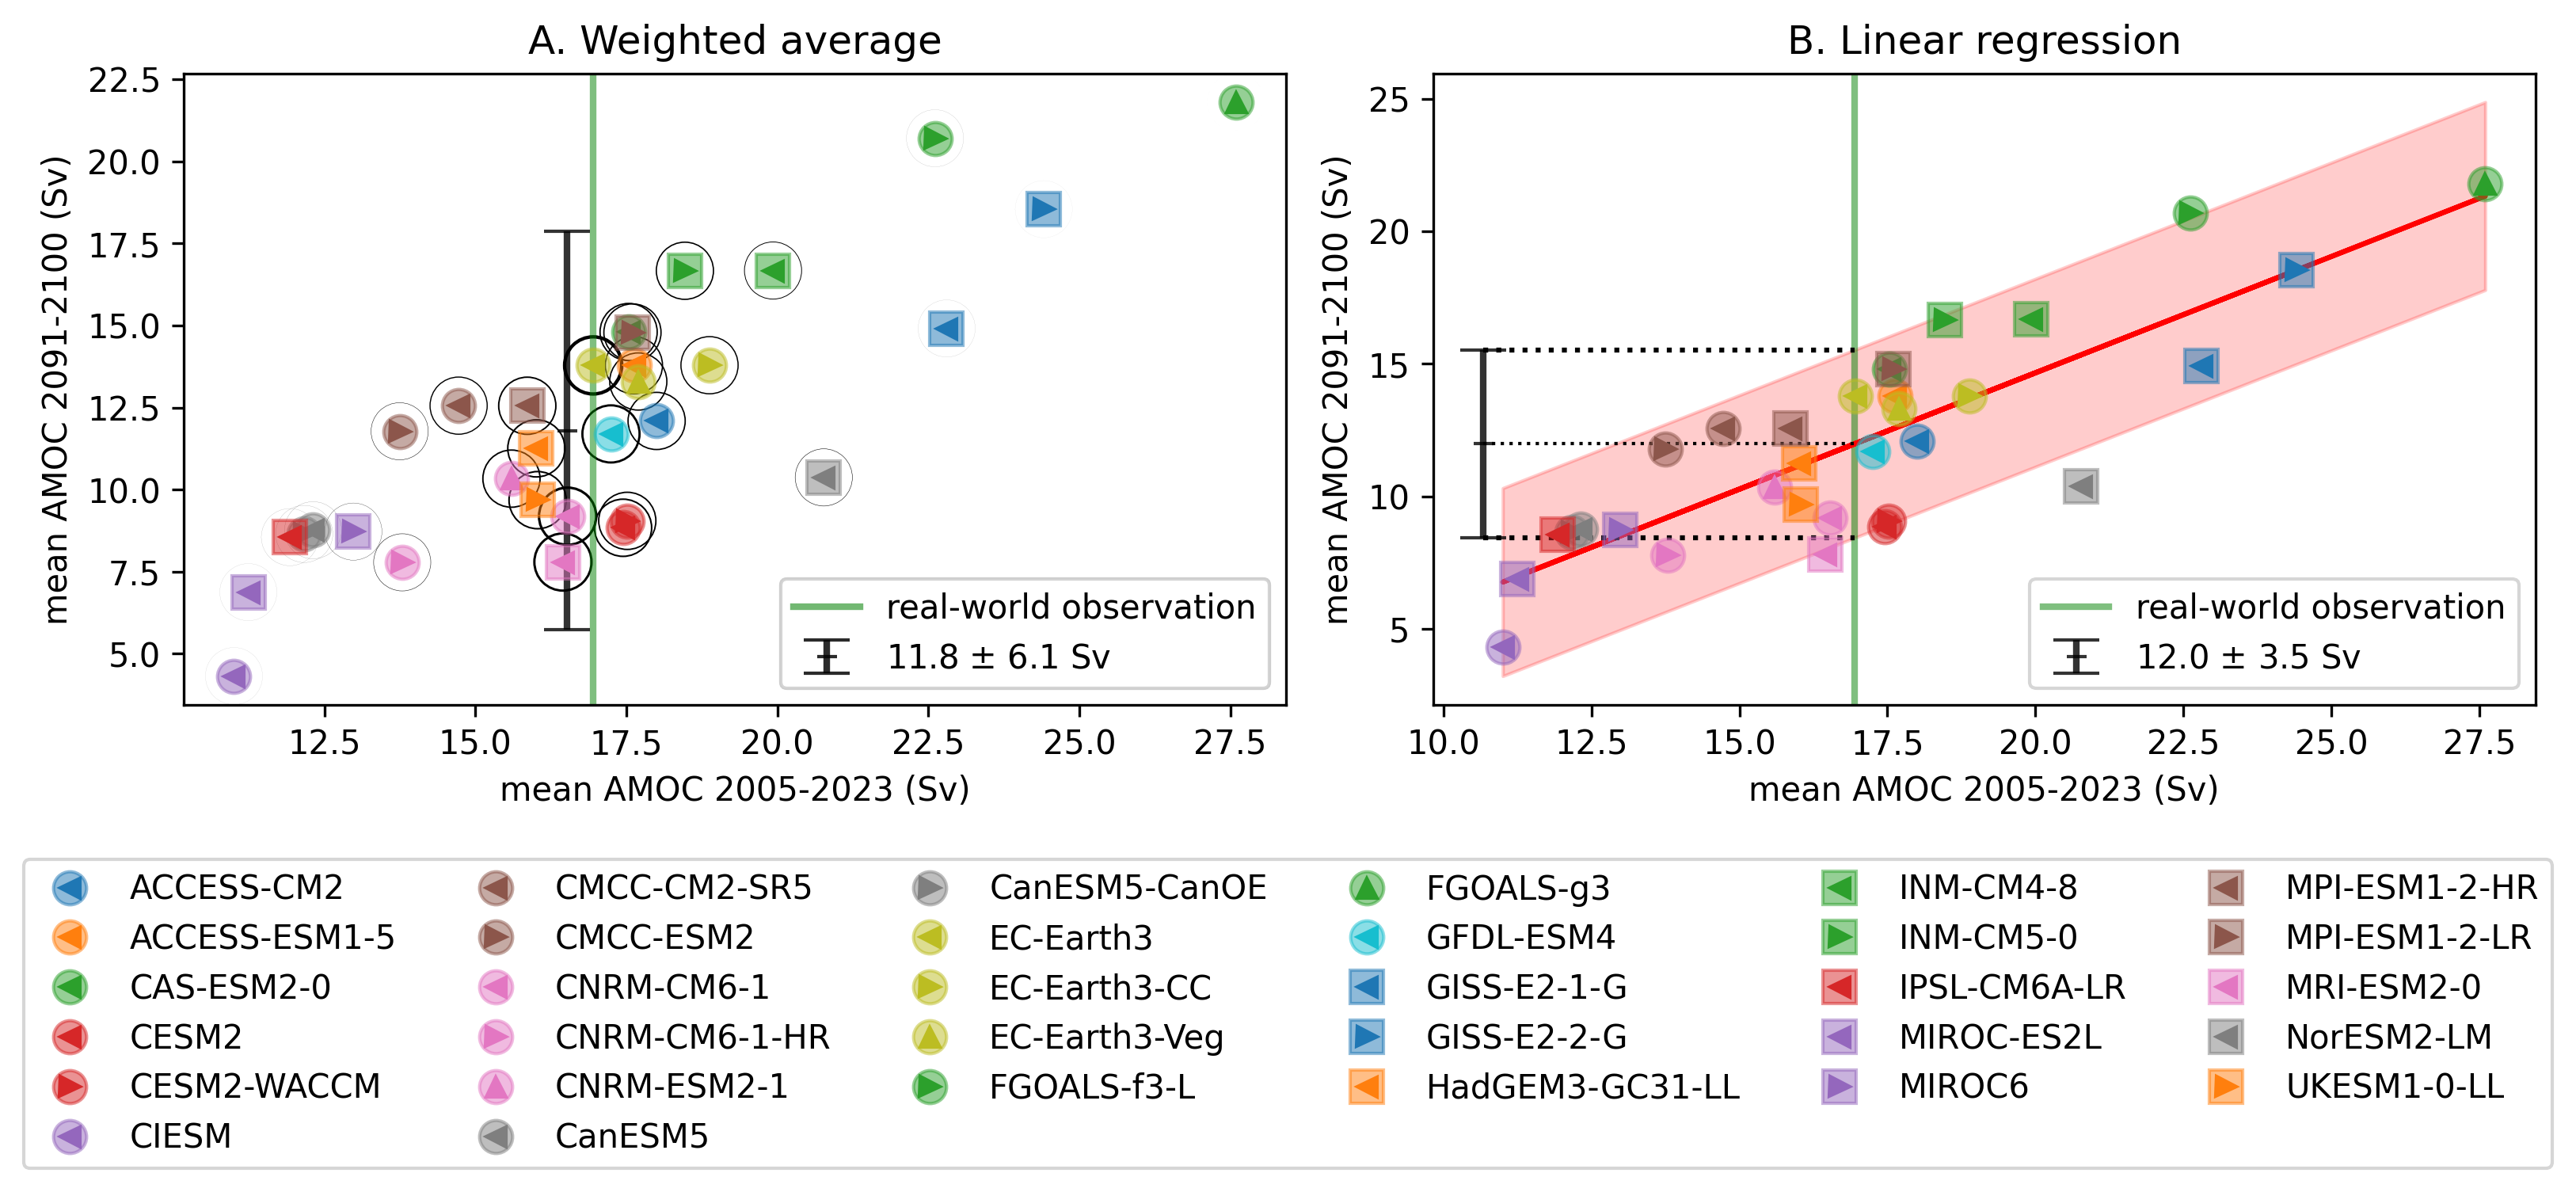

In [14]:
display_univariate_WeightedAverage_LinearRegression(X_simu_AMOC, X_simu, Y_simu,
                                                    X_obs_AMOC, X_obs,
                                                    list_list_std_without, list_list_predictions,
                                                    name_Y, name_X_AMOC, final_name_models,
                                                    poids_wA, probability=0.90)

# Decompose the correction induced by the observational constraint made by ridge regression when using multiple observable variables

In [15]:
from sklearn.preprocessing import StandardScaler
from OC_methods import model_RidgeCV_noisy


# Compute the coefficients of Ridge regression
scaler = StandardScaler()
X_simu_n = scaler.fit_transform(X_simu)
X_obs_n = scaler.transform(X_obs.reshape(1,-1))
model = model_RidgeCV_noisy(Cov_obs=0).fit(X_simu_n, Y_simu)
Beta = model.model.coef_
intercept = model.model.intercept_


#----------------------------------------------------------------------------------
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

In [16]:
name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)

list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)

In [17]:
# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2






,$\beta$,($X_0$-$\mu_{X}$),$\beta$ ($X_0$-$\mu_{X}$)
mean AMOC 2005-2023,1.60,-0.01,-0.02
tos Atlantic South,0.14,-0.07,-0.01
sos Atlantic South,-1.26,0.96,-1.20
tos Subtropical,-0.82,1.11,-0.90
sos Subtropical,0.26,-0.15,-0.04
tos Tropical South,0.05,-2.32,-0.11
sos Tropical South,-0.58,1.13,-0.65
tos Tropical North,-0.57,0.31,-0.17
sos Tropical North,0.98,-0.33,-0.32
tos Labrador,0.18,0.41,0.07


In [18]:
np.sum(data[:,2])

-3.9294010736637905

In [19]:


#----------------------------------------------------------------------------------
def display_importance_per_feature(mean_importance_perfeature,
                                   mask_perVar, list_idCell_perFeature,
                                   list_id_box_perFeature, list_id_var_perFeature,
                                   display_AMOC=False, shrink=1.0, nb_slots_cmap=10):
    
    fontsize = 20
    
    nb_lon = len(longitudes)
    nb_lat = len(latitudes)
    nb_features = len(mean_importance_perfeature)
    indexes_sos = list(np.arange(1,nb_features, 2))
    indexes_tos = list(np.arange(0,nb_features, 2))

    mean_importance_perCell_tos = np.zeros(np.sum(mask_perVar[0]))
    mean_importance_perCell_sos = np.zeros(np.sum(mask_perVar[1]))

    for id_feature in range(nb_features-1):
        id_cells = list_idCell_perFeature[id_feature]
        id_box   = list_id_box_perFeature[id_feature]
        if list_id_var_perFeature[id_feature]==0:
            mean_importance_perCell_tos[id_cells] = mean_importance_perfeature[id_feature]
        elif list_id_var_perFeature[id_feature]==1:
            mean_importance_perCell_sos[id_cells] = mean_importance_perfeature[id_feature]



    map_coefs_tos = reverse_mask(mean_importance_perCell_tos, np.logical_not(mask_perVar[0]))
    map_coefs_sos = reverse_mask(mean_importance_perCell_sos, np.logical_not(mask_perVar[1]))


    mM = np.nanmax(np.abs(mean_importance_perfeature))
    mM = (np.ceil(10*mM)+(np.ceil(10*mM)%2))/10
    #mM = np.ceil(10*mM)/10
    # Colormap
    cmap = plt.cm.coolwarm
    import matplotlib as mpl
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(-mM, mM, nb_slots_cmap)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    

    plt.figure()
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,2.5))
    if display_AMOC:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7), dpi=300)
    else:
        alpha = 1.8
        #fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(alpha*6, alpha*6))
        fig, (ax3, ax2) = plt.subplots(1,2, figsize=(alpha*12, alpha*3), dpi=300)
    
    flipped_image      = np.flip(map_coefs_tos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    ax2.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax2.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax2.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax2.set_xticks([])
    ax2.set_yticks([])
    #ax2.set_ylabel("latitude", fontsize=None)
    #ax2.set_xlabel("longitude", fontsize=None)
    ax2.set_title("B. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{temperature}$", fontsize=20)
    #ax2.colorbar(shrink=0.6)
    
    flipped_image      = np.flip(map_coefs_sos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    im = ax3.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax3.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax3.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax3.set_xticks([])
    ax3.set_yticks([])
    #ax3.set_ylabel("latitude", fontsize=None)
    #ax3.set_xlabel("longitude", fontsize=None)
    ax3.set_title("A. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{salinity}$", fontsize=fontsize)
    

    
    if display_AMOC:
        im_bis = np.copy(translate_image)
        im_bis[np.logical_not(np.isnan(im_bis))] = 0
        ax1.imshow(im_bis, interpolation='none', cmap=cmap, norm=norm)#, vmin=-mM, vmax=mM)    
        ax1.set_title("2005-2023 AMOC importance")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.get_ylim()
        id_ = np.argmin(np.abs(flipped_latitudes-26))
        #ax1.axhline(y=id_) #, c=mean_importance_perfeature[-1], cmap="coolwarm", vmin=-mM, vmax=mM)
        id_longitudes_kept = np.where(np.logical_and(flipped_longitudes>-80, flipped_longitudes<-15))[0]
        ax1.scatter(id_longitudes_kept,
                    np.repeat(id_, len(id_longitudes_kept)),
                    c=np.repeat(mean_importance_perfeature[-1], len(id_longitudes_kept)),
                    cmap="coolwarm", vmin=-mM, vmax=mM, s=5)

        ax1.set_yticks(ticks=[id_], labels=["26°N"])
        cbar = fig.colorbar(im, ax=[ax1, ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')
    else:
        cbar = fig.colorbar(im, ax=[ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')#, anchor=(0.5, 1.8))
    cbar.set_label(label='(Sv)', size=fontsize, rotation=0)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    #ax1.colorbar(shrink=0.6)

    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=8, wspace=0.03, hspace=None)
    #plt.tight_layout()

<Figure size 640x480 with 0 Axes>

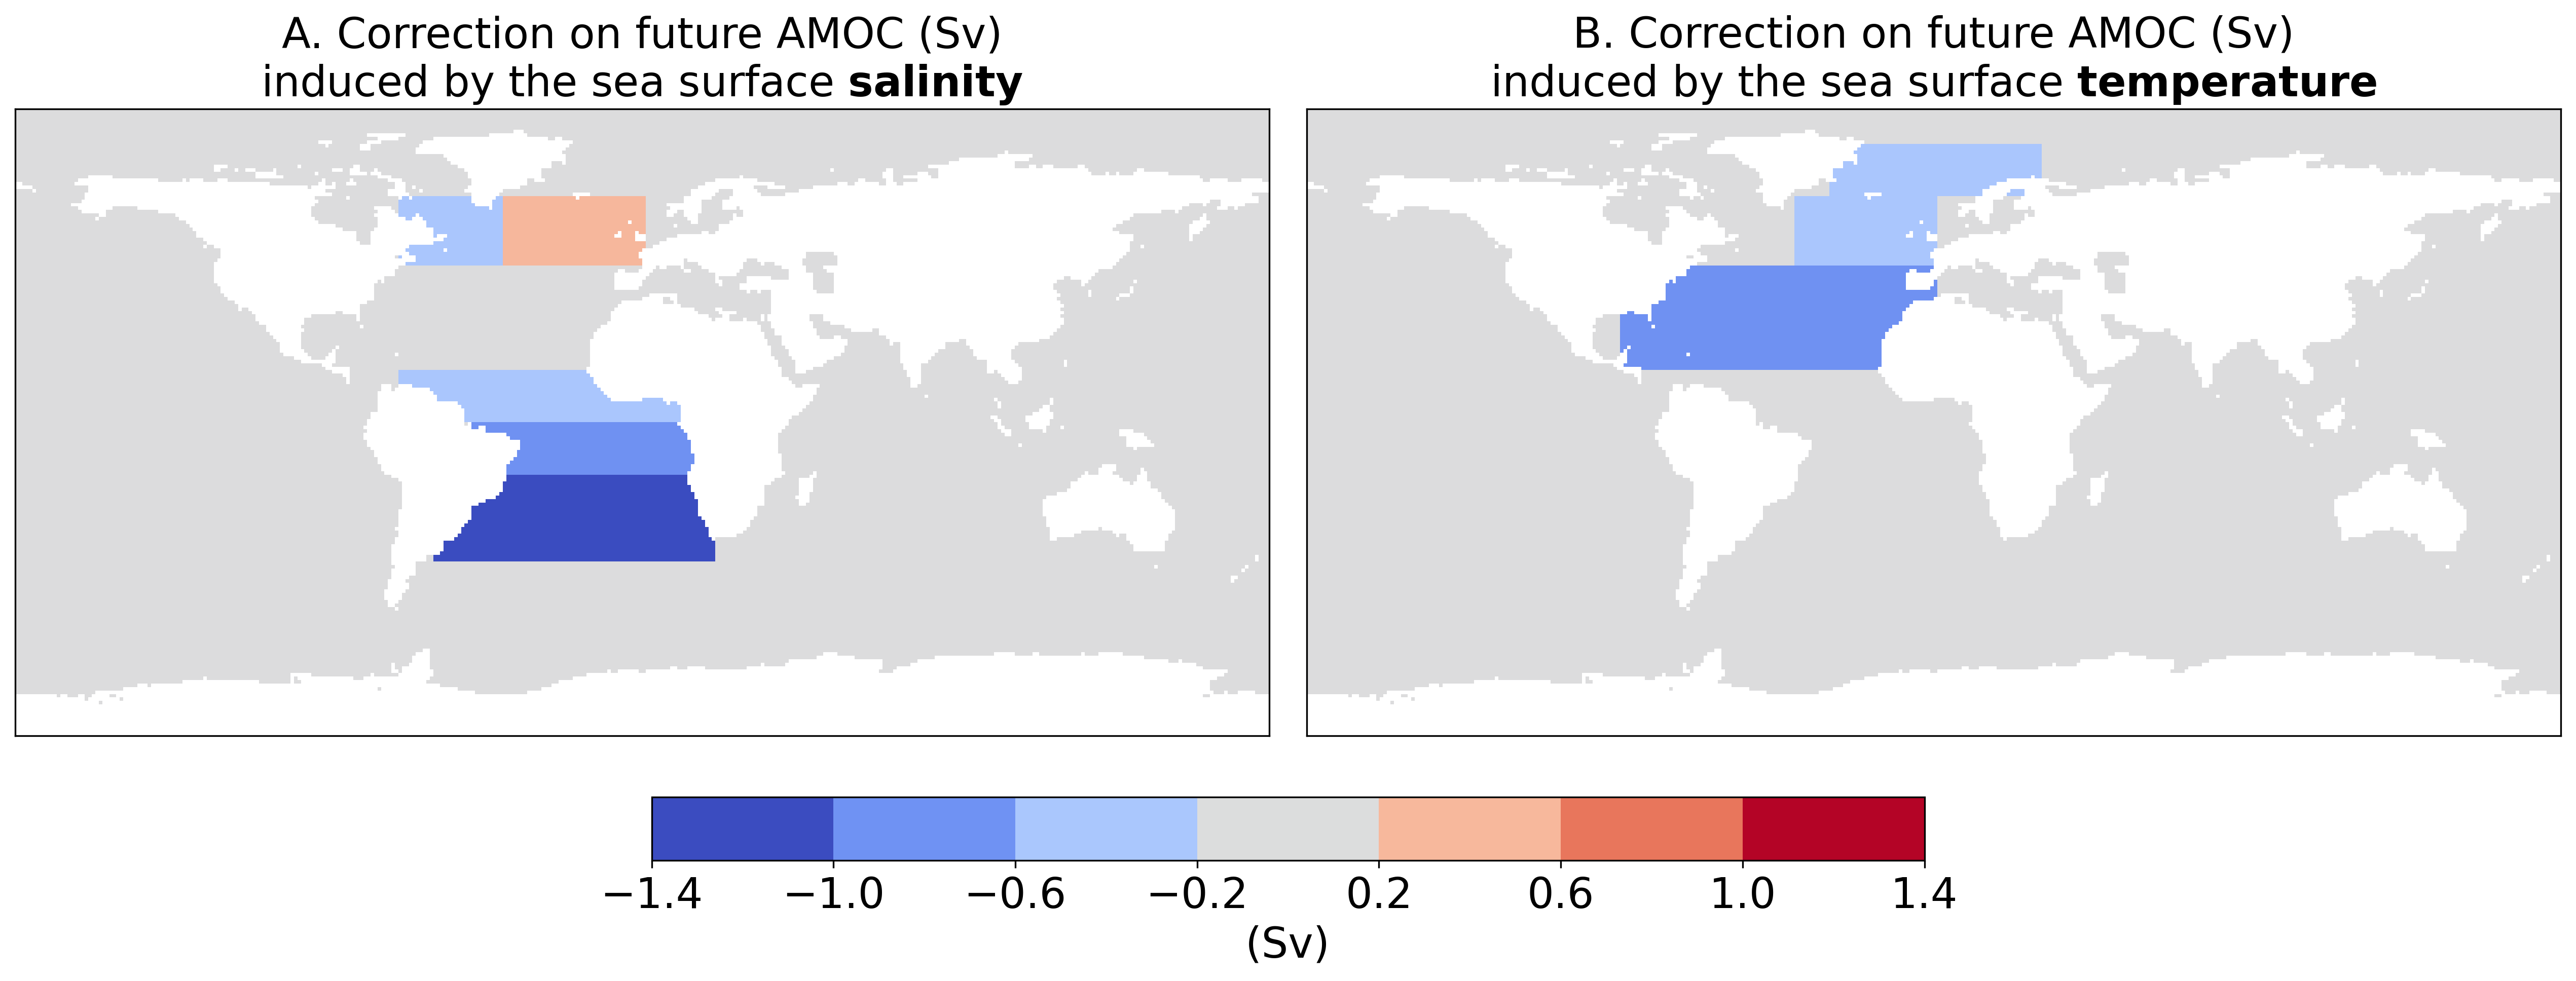

In [20]:
#----------------------------------------------------------------------------------
#model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu, Y_simu)

model = model_RidgeCV_noisy(Cov_obs=0).fit(X_simu, Y_simu)
Beta  = model.model.coef_
X_obs_n = model.scaler.transform(X_obs.reshape(1,-1))
X_simu_n = model.scaler.transform(X_simu)

#----------------------------------------------------------------------------------
mean_importance_perfeature = Beta*(X_obs_n-np.mean(X_simu_n, axis=0))[0] # (model.model.coef_.T*(X_obs_n-np.mean(X_simu_n, axis=0)))
display_importance_per_feature(mean_importance_perfeature,
                               mask_perVar, list_idCell_perFeature,
                               list_id_box_perFeature, list_id_var_perFeature,
                               shrink=0.5, nb_slots_cmap=8, display_AMOC=False)


In [21]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

indexes = np.flip(np.argsort(np.abs(data[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




,$\beta$,($X_0$-$\mu_{X}$),$\beta$ ($X_0$-$\mu_{X}$)
sos Atlantic South,-1.26,0.96,-1.20
tos Subtropical,-0.82,1.11,-0.90
sos Tropical South,-0.58,1.13,-0.65
sos Subpolar East,0.81,0.56,0.46
tos Subpolar East,-0.41,0.79,-0.33
sos Labrador,-0.60,0.54,-0.33
sos Tropical North,0.98,-0.33,-0.32
tos Nordic Seas,-0.24,0.95,-0.23
tos Tropical North,-0.57,0.31,-0.17
sos Indian Ocean,-0.36,0.42,-0.15


In [22]:
pd.set_option("display.precision", 2)

name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)


data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)


list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)




indexes = np.flip(np.argsort(np.abs(data_bis[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data_bis[indexes], index=np.array(list_name_feature_bis)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data_bis[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data_bis[:, 2]))))>percent_*np.sum(np.abs(data_bis[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




,$\beta$,($X_0$-$\mu_{X}$),$\beta$ ($X_0$-$\mu_{X}$)
tos & sos Atlantic South,-1.12,0.89,-1.21
tos & sos Subtropical,-0.55,0.95,-0.94
tos & sos Tropical South,-0.53,-1.19,-0.76
tos & sos Tropical North,0.40,-0.02,-0.49
tos & sos Labrador,-0.42,0.95,-0.25
tos & sos Nordic Seas,-0.24,0.88,-0.23
tos & sos Indian Ocean,-0.42,1.00,-0.18
tos & sos Subpolar East,0.40,1.36,0.13
tos & sos Nino,0.46,0.22,0.03
mean AMOC 2005-2023,1.60,-0.01,-0.02


In [23]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)



# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2



,$\beta$,($X_0$-$\mu_{X}$),$\beta$ ($X_0$-$\mu_{X}$)
mean AMOC 2005-2023,1.60,-0.01,-0.02
tos Atlantic South,0.14,-0.07,-0.01
sos Atlantic South,-1.26,0.96,-1.20
tos Subtropical,-0.82,1.11,-0.90
sos Subtropical,0.26,-0.15,-0.04
tos Tropical South,0.05,-2.32,-0.11
sos Tropical South,-0.58,1.13,-0.65
tos Tropical North,-0.57,0.31,-0.17
sos Tropical North,0.98,-0.33,-0.32
tos Labrador,0.18,0.41,0.07


# Article's value

In [24]:
# Probability
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]
print(z)

1.6448536269514722


In [25]:
Y_simu_percent = (Y_simu-Y_ref)/Y_ref
print("AMOC slow down: {:.1f} Sv +- {:.1f} ({} % probability)".format(
    np.mean(Y_simu), z*np.std(Y_simu), int(100*conf)))

ref = np.mean(Y_ref)

print("\nReference ({}-{} average on CMIP6 models): {:.1f} +- {:.1f} Sv".format(
    min_Y_ref, max_Y_ref, ref, z*np.std(Y_ref)))

print("Unconstrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(np.mean(Y_simu)-ref)/ref, 100*z*np.std(Y_simu)/ref, int(100*conf)))



# Best guess (in the sense of Leave-One-Out (LOO) cross-validation error)
if return_LOOperFold:
    list_list_LOO_cpy    = np.mean(np.array(list_list_LOO), axis=2)
else:
    list_list_LOO_cpy    = np.array(list_list_LOO)
best_guess       = np.array(list_list_predictions)[np.where(list_list_LOO_cpy==np.min(list_list_LOO_cpy))][0]
best_guess_error = np.array(list_list_std_without)[np.where(list_list_LOO_cpy==np.min(list_list_LOO_cpy))][0]



best_guess, best_guess_error
print("Constrained AMOC slow down: {:.1f} +- {:.1f} ({} % probability)".format(
    best_guess, z*best_guess_error, int(100*conf)))
print("Constrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(best_guess-ref)/ref, 100*z*best_guess_error/ref, int(100*conf)))

print("Reduction of uncertainty: {:.1f} %".format(100*(np.std(Y_simu)-best_guess_error)/np.std(Y_simu)))
print("Stronger AMOC decline by {:.1f} %".format(100*(best_guess-np.mean(Y_simu))/np.mean(Y_simu)))

AMOC slow down: 12.0 Sv +- 6.5 (90 % probability)

Reference (1850-1900 average on CMIP6 models): 17.7 +- 6.7 Sv
Unconstrained AMOC slow down: -32.2 % +- 36.6 % (90 % probability)
Constrained AMOC slow down: 8.1 +- 1.4 (90 % probability)
Constrained AMOC slow down: -54.4 % +- 7.8 % (90 % probability)
Reduction of uncertainty: 78.8 %
Stronger AMOC decline by -32.7 %
